
# GARCH(1,1) — ANN (acov_multi) + μ via WLS + MLE (Gauss & t)

Mises à jour clés :
- Proxy α₁ **robuste** (multi-fenêtres / multi-guesses).
- Dataset : fenêtres **longues** (`win=768`) & pas **dense** (`step=16`), winsorisation 1%.
- Modèle : **MSE** + léger **dropout** (0.02), scheduler + early-stop.
- Calibration finale d’α₁ (isotone si dispo, sinon linéaire).
- Benchmarks : **NLL/AIC** (Gauss & Student-t), **profil ν** et **heatmap (ν, μ)**.

Le notebook lit `return.csv`/`returns.csv` s’ils sont présents, sinon **simule** une série GARCH(1,1).


In [1]:

import os, sys, math, json, warnings
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import scipy.optimize as spo
from scipy.special import gammaln

def set_seed(s=1337):
    np.random.seed(s); torch.manual_seed(s)
set_seed(1337)

BASE = Path(".")


## 1. Données — lecture `return.csv` (sinon simulation)

In [2]:

csv_candidates = [BASE/'return.csv', BASE/'returns.csv']
ret_path = next((p for p in csv_candidates if p.exists()), None)

if ret_path is not None:
    df = pd.read_csv(ret_path)
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not num_cols:
        raise ValueError("No numeric column found in CSV.")
    rets = df[num_cols[0]].astype(float).values
    print(f"Loaded {ret_path} with {len(rets)} rows.")
else:
    T = 5000
    a0, a1, b1 = 2e-6, 0.08, 0.90
    eps = np.random.randn(T); h = np.zeros(T); x = np.zeros(T)
    h[0] = a0/(1-(a1+b1))
    for t in range(1,T):
        h[t] = a0 + a1*x[t-1]**2 + b1*h[t-1]
        x[t] = np.sqrt(h[t]) * eps[t]
    rets = x
    print("Simulated GARCH(1,1) since no CSV found.",
          f"T={T}, true alpha0={a0}, alpha1={a1}, beta1={b1}")
rets = rets - np.nanmean(rets); T = len(rets); print("T =", T)


Loaded returns.csv with 10000 rows.
T = 10000


## 2. Utilitaires — $\hat\gamma_n$, WLS($\mu$), NLL

In [3]:

def sample_acov(x, lag):
    if lag<=0: return np.nan
    x = np.asarray(x)
    x0 = x[:-lag]; x1 = x[lag:]
    return np.mean(x0 * x1)

def gamma_hat_series(x, lags):
    v = np.var(x)
    g = []
    for n in lags:
        ac = sample_acov(x, n)
        g.append(ac / v if v>0 else np.nan)
    return np.array(g), v

def estimate_mu_wls(g, lags):
    x = (lags - 1).astype(float)
    y = np.log(np.maximum(g, 1e-12))
    w = 1.0/np.maximum(x,1.0)
    X = np.vstack([np.ones_like(x), -x]).T
    W = np.diag(w)
    beta = np.linalg.pinv(X.T @ W @ X) @ (X.T @ W @ y)
    mu = np.exp(-beta[1])
    return float(np.clip(mu, 1e-6, 0.995))

def estimate_mu_wls_alt(g, lags, T_eff=None):
    x = (lags - 1).astype(float)
    y = np.log(np.maximum(g, 1e-12))
    if T_eff is None: T_eff = lags.max() + 512
    w = (T_eff - lags).astype(float); w[w<=0] = 1.0
    X = np.vstack([np.ones_like(x), -x]).T
    W = np.diag(w)
    beta = np.linalg.pinv(X.T @ W @ X) @ (X.T @ W @ y)
    mu = np.exp(-beta[1])
    return float(np.clip(mu, 1e-6, 0.995))

def nll_gaussian(a0,a1,b1, x):
    if a0<=0 or a1<0 or b1<0 or a1+b1>=0.9999: return 1e12
    T=len(x); h=np.empty(T); varx=np.var(x)
    h[0]=max(a0/(1-(a1+b1)), 1e-10) if a1+b1<1 else max(varx,1e-6)
    for t in range(1,T):
        h[t]=a0 + a1*x[t-1]**2 + b1*h[t-1]
        if h[t]<=0: return 1e12
    return 0.5*np.sum(np.log(h) + (x**2)/h) + 0.5*T*np.log(2*np.pi)

def nll_student(a0,a1,b1, nu, x):
    if nu<=2.0 or not np.isfinite(nu): return 1e12
    if a0<=0 or a1<0 or b1<0 or a1+b1>=0.9999: return 1e12
    T=len(x); h=np.empty(T); varx=np.var(x)
    h[0]=max(a0/(1-(a1+b1)), 1e-10) if a1+b1<1 else max(varx,1e-6)
    for t in range(1,T):
        h[t]=a0 + a1*x[t-1]**2 + b1*h[t-1]
        if h[t]<=0: return 1e12
    c0 = gammaln((nu+1)/2) - gammaln(nu/2) - 0.5*np.log((nu-2)*np.pi)
    return -np.sum(c0 - 0.5*np.log(h) - ((nu+1)/2)*np.log(1.0 + (x**2/h)/(nu-2)))

def aic_from_nll(nll, k): return 2*k + 2*nll


## 3. Lags / features

In [4]:

lags = np.arange(3, 17)
g_hat, sigma2_hat = gamma_hat_series(rets, lags)
print("sigma^2_hat =", sigma2_hat)
print("gamma_hat[:5] =", g_hat[:5])


sigma^2_hat = 8.70647885666553e-05
gamma_hat[:5] = [ 0.01563535  0.00113978  0.02478361 -0.01182258 -0.00397075]


## 4. Proxy α₁ robuste (Patch C)

In [5]:

def estimate_alpha1_local_mle_robust(sub):
    lsets = [np.arange(3,10), np.arange(4,12)]
    guesses = [0.05, 0.08, 0.12]
    best_val, best_a1 = np.inf, np.nan

    def nll_gauss_tuple(a0,a1,b1,x):
        if a0<=0 or a1<0 or b1<0 or a1+b1>=0.9999: return 1e12
        T=len(x); h=np.empty(T); varx=np.var(x)
        h[0]=max(a0/(1-(a1+b1)), 1e-10) if a1+b1<1 else max(varx,1e-6)
        for t in range(1,T):
            h[t]=a0 + a1*x[t-1]**2 + b1*h[t-1]
            if h[t]<=0: return 1e12
        return 0.5*np.sum(np.log(h) + (x**2)/h) + 0.5*T*np.log(2*np.pi)

    for lshort in lsets:
        gsub, s2sub = gamma_hat_series(sub, lshort)
        mu = estimate_mu_wls(gsub, lshort)
        for g0 in guesses:
            def obj(a1):
                a1 = float(a1)
                b1 = float(np.clip(mu - a1, 1e-6, 0.999))
                a0 = float(np.clip(s2sub*(1-mu), 1e-12, 1.0))
                return nll_gauss_tuple(a0,a1,b1, sub)
            res = spo.minimize(lambda z: obj(z[0]), x0=[g0], bounds=[(1e-6,0.99)])
            if res.success and res.fun < best_val:
                best_val, best_a1 = float(res.fun), float(res.x[0])
    return best_a1


## 5. Dataset — fenêtres longues + pas dense + winsorisation 

In [6]:

def build_dataset_from_series(x, lags, win=768, step=16, include_sigma=True):
    Xs, ys = [], []
    N = len(x)
    for start in range(0, N - win - lags[-1], step):
        sub = x[start:start+win+lags[-1]]
        g, s2 = gamma_hat_series(sub, lags)
        feat = np.concatenate([g, [np.log(max(s2, 1e-12))]]) if include_sigma else g
        a1_proxy = estimate_alpha1_local_mle_robust(sub)
        if np.isfinite(a1_proxy):
            Xs.append(feat); ys.append(a1_proxy)
    X = np.vstack(Xs).astype(np.float32)
    y = np.array(ys, dtype=np.float32).reshape(-1,1)
    return X, y

X, y = build_dataset_from_series(rets, lags, win=768, step=16, include_sigma=True)
yl, yu = np.quantile(y, 0.01), np.quantile(y, 0.99)
mask = (y >= yl) & (y <= yu)
X, y = X[mask.ravel()], y[mask.ravel()]
print("Dataset shapes (filtered):", X.shape, y.shape)


Dataset shapes (filtered): (564, 15) (564, 1)


## 6. Split / standardisation / entraînement (MSE + léger dropout)

Best val MSE: 0.0006654405733570457 at epoch 82


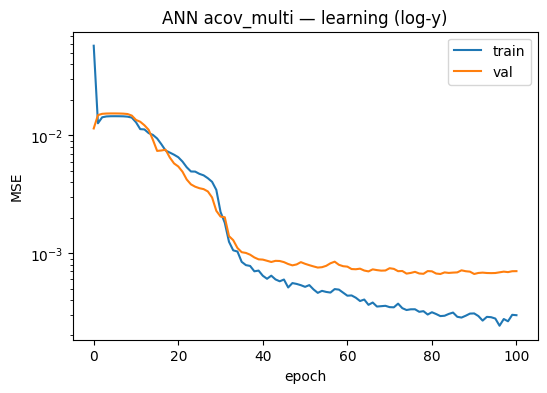

In [7]:

from sklearn.model_selection import train_test_split
Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.2, random_state=42)

mx, sx = Xtr.mean(axis=0), Xtr.std(axis=0) + 1e-9
Xtrn, Xvan = (Xtr - mx)/sx, (Xval - mx)/sx

device = "cpu"
Xt = torch.tensor(Xtrn, dtype=torch.float32).to(device)
Xv = torch.tensor(Xvan, dtype=torch.float32).to(device)
yt = torch.tensor(ytr, dtype=torch.float32).to(device)
yv = torch.tensor(yval, dtype=torch.float32).to(device)

train_loader = DataLoader(TensorDataset(Xt, yt), batch_size=128, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xv, yv), batch_size=256, shuffle=False)

class MLP(nn.Module):
    def __init__(self, d_in, d_hidden=192, pdrop=0.02):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, d_hidden), nn.ReLU(), nn.Dropout(pdrop),
            nn.Linear(d_hidden, d_hidden), nn.ReLU(), nn.Dropout(pdrop),
            nn.Linear(d_hidden, 1), nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

model = MLP(Xtrn.shape[1], d_hidden=192, pdrop=0.02).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=1e-5)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=12, verbose=False)
crit = nn.MSELoss()

best = {"val": float("inf"), "state": None, "epoch": -1}
train_losses, val_losses = [], []
no_improve, early_patience = 0, 18

for epoch in range(250):
    model.train(); tl=0.0
    for xb,yb in train_loader:
        opt.zero_grad()
        loss = crit(model(xb), yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        tl += float(loss.detach()) * len(xb)
    tl /= len(train_loader.dataset); train_losses.append(tl)

    model.eval(); vl=0.0
    with torch.no_grad():
        for xb,yb in val_loader:
            vl += float(crit(model(xb), yb)) * len(xb)
    vl /= len(val_loader.dataset); val_losses.append(vl)

    sched.step(vl)
    if vl + 1e-12 < best["val"]:
        best = {"val": vl, "state": {k:v.cpu().clone() for k,v in model.state_dict().items()}, "epoch": epoch}
        no_improve = 0
    else:
        no_improve += 1
    if no_improve >= early_patience:
        break

model.load_state_dict(best["state"])
print("Best val MSE:", best["val"], "at epoch", best["epoch"])

plt.figure(figsize=(6,4))
plt.plot(train_losses, label="train"); plt.plot(val_losses, label="val")
plt.yscale("log"); plt.xlabel("epoch"); plt.ylabel("MSE"); plt.title("ANN acov_multi — learning (log-y)")
plt.legend(); plt.show()


## 7. Évaluation (MSE/R²) + Calibration finale

MSE(val) = 0.000665  |  RMSE = 0.0258
Baseline MSE(mean-target) = 0.003504
R^2(val) = 0.810


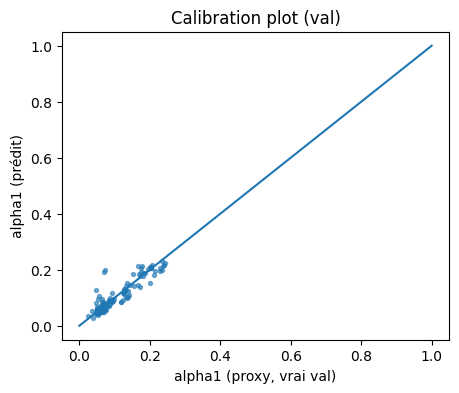

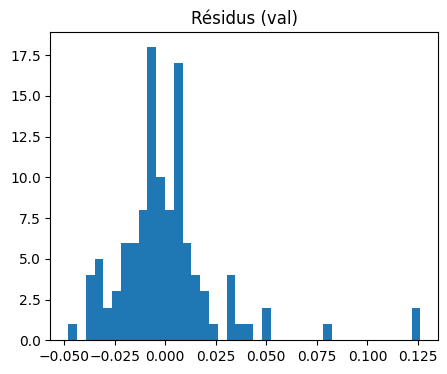

Calibration: isotone


In [8]:

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

model.eval()
with torch.no_grad():
    yhat_val_raw = model(torch.tensor(Xvan, dtype=torch.float32)).cpu().numpy().ravel()

mse_val = mean_squared_error(yval.ravel(), yhat_val_raw)
rmse_val = float(np.sqrt(mse_val))
r2 = r2_score(yval.ravel(), yhat_val_raw)
mse_baseline = mean_squared_error(yval.ravel(), np.full_like(yval.ravel(), ytr.mean()))
print(f"MSE(val) = {mse_val:.6f}  |  RMSE = {rmse_val:.4f}")
print(f"Baseline MSE(mean-target) = {mse_baseline:.6f}")
print(f"R^2(val) = {r2:.3f}")

plt.figure(figsize=(5,4))
plt.scatter(yval.ravel(), yhat_val_raw, s=8, alpha=0.6)
plt.plot([0,1],[0,1])
plt.xlabel("alpha1 (proxy, vrai val)"); plt.ylabel("alpha1 (prédit)")
plt.title("Calibration plot (val)"); plt.show()

res = yhat_val_raw - yval.ravel()
plt.figure(figsize=(5,4)); plt.hist(res, bins=40)
plt.title("Résidus (val)"); plt.show()

try:
    from sklearn.isotonic import IsotonicRegression
    cal = IsotonicRegression(out_of_bounds="clip").fit(yhat_val_raw, yval.ravel())
    def calibrate(a1_raw): return float(np.clip(cal.predict([a1_raw])[0], 1e-6, 0.999))
    print("Calibration: isotone")
except Exception:
    lin = LinearRegression().fit(yhat_val_raw.reshape(-1,1), yval.ravel())
    def calibrate(a1_raw): return float(np.clip(lin.intercept_ + lin.coef_[0]*a1_raw, 1e-6, 0.999))
    print("Calibration: linéaire")


## 8. Paramètres ANN finaux (+ μ via WLS)

In [9]:

feat_full = np.concatenate([g_hat, [np.log(max(sigma2_hat, 1e-12))]]).astype(np.float32)
feat_full_std = (feat_full - mx)/sx
with torch.no_grad():
    a1_raw = float(model(torch.tensor(feat_full_std).unsqueeze(0)).cpu().numpy().ravel()[0])
a1_hat = calibrate(a1_raw)

mu_hat = estimate_mu_wls_alt(g_hat, lags)
mu_hat = float(np.clip(mu_hat, 1e-6, 0.985))
b1_hat = float(np.clip(mu_hat - a1_hat, 1e-6, 0.999))
a0_hat = float(np.clip(sigma2_hat*(1-mu_hat), 1e-12, 1.0))
params_ann = {"alpha0": a0_hat, "alpha1": a1_hat, "beta1": b1_hat}
print("Params ANN finaux:", params_ann, "| mu_hat≈", mu_hat, "| sum≈", a1_hat+b1_hat)


Params ANN finaux: {'alpha0': 1.3059718284998307e-06, 'alpha1': 0.23787440359592438, 'beta1': 0.7471255964040756} | mu_hat≈ 0.985 | sum≈ 0.985


## 9. MLE (Gauss & Student‑t)

In [10]:
def mle_gauss(x, x0=(2e-6, 0.08, 0.90)):
    bounds=[(1e-12,1.0),(1e-6,0.999),(1e-6,0.999)]
    res = spo.minimize(lambda p: nll_gaussian(p[0],p[1],p[2],x), x0=x0, bounds=bounds, method="L-BFGS-B")
    a0,a1,b1 = res.x
    return {"alpha0":float(a0),"alpha1":float(a1),"beta1":float(b1),"nll":float(res.fun),"success":res.success}

def mle_student_t(x, x0=(2e-6,0.08,0.90,6.5)):
    bounds=[(1e-12,1.0),(1e-6,0.999),(1e-6,0.999),(2.05,100.0)]
    res = spo.minimize(lambda p: nll_student(p[0],p[1],p[2],p[3],x), x0=x0, bounds=bounds, method="L-BFGS-B")
    a0,a1,b1,nu = res.x
    return {"alpha0":float(a0),"alpha1":float(a1),"beta1":float(b1),"nu":float(nu),"nll":float(res.fun),"success":res.success}

mle_g = mle_gauss(rets)
mle_t = mle_student_t(rets, x0=(mle_g["alpha0"],mle_g["alpha1"],mle_g["beta1"],6.5))
print("MLE (Gauss):", mle_g)
print("MLE (Student-t):", mle_t)


MLE (Gauss): {'alpha0': 1.7949296564399747e-06, 'alpha1': 0.07997510251147558, 'beta1': 0.8997199000875485, 'nll': -33526.969252319854, 'success': True}
MLE (Student-t): {'alpha0': 1.8684140419109526e-06, 'alpha1': 0.07997517004557662, 'beta1': 0.8997199073830988, 'nu': 6.500000234411506, 'nll': -33725.685649379884, 'success': True}


## 10. Benchmark ANN vs MLE — NLL/AIC (Gauss & t) + Profils

                          method    alpha0    alpha1     beta1        nu  \
0                    ANN (Gauss)  0.000001  0.237874  0.747126       NaN   
1  ANN (Student-t, nu fixé=6.50)  0.000001  0.237874  0.747126  6.500000   
2    ANN (Student-t, nu profilé)  0.000001  0.237874  0.747126  7.114573   
3                    MLE (Gauss)  0.000002  0.079975  0.899720       NaN   
4                MLE (Student-t)  0.000002  0.079975  0.899720  6.500000   

            NLL           AIC  
0 -33032.019198 -66058.038397  
1 -33421.126605 -66834.253210  
2 -33423.724361 -66839.448721  
3 -33526.969252 -67047.938505  
4 -33725.685649 -67443.371299  


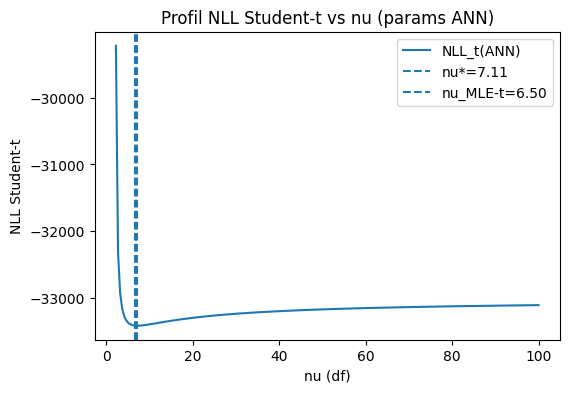

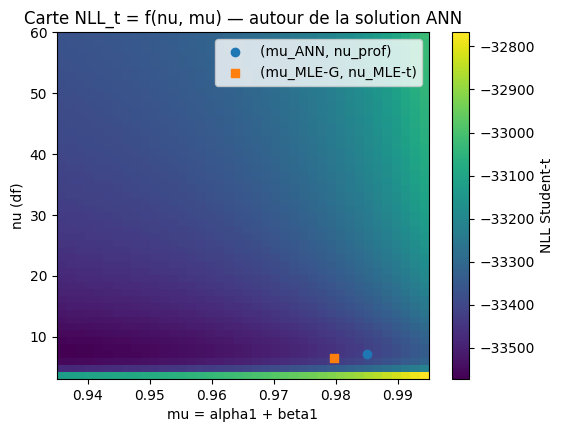

In [11]:
nll_ann_g = nll_gaussian(params_ann["alpha0"], params_ann["alpha1"], params_ann["beta1"], rets)
nu_fix = mle_t.get("nu", 6.8)
nll_ann_t_fix = nll_student(params_ann["alpha0"], params_ann["alpha1"], params_ann["beta1"], nu_fix, rets)

nu_grid = np.linspace(2.2, 100, 200)
vals = np.array([nll_student(params_ann["alpha0"], params_ann["alpha1"], params_ann["beta1"], nu, rets) for nu in nu_grid])
nu_prof = float(nu_grid[np.argmin(vals)])
nll_ann_t_prof = float(vals.min())

import pandas as pd
summary = pd.DataFrame([
    {"method":"ANN (Gauss)", "alpha0":params_ann["alpha0"], "alpha1":params_ann["alpha1"], "beta1":params_ann["beta1"], "nu":np.nan, "NLL":nll_ann_g, "AIC":aic_from_nll(nll_ann_g, 3)},
    {"method":f"ANN (Student-t, nu fixé={nu_fix:.2f})", "alpha0":params_ann["alpha0"], "alpha1":params_ann["alpha1"], "beta1":params_ann["beta1"], "nu":nu_fix, "NLL":nll_ann_t_fix, "AIC":aic_from_nll(nll_ann_t_fix, 4)},
    {"method":"ANN (Student-t, nu profilé)", "alpha0":params_ann["alpha0"], "alpha1":params_ann["alpha1"], "beta1":params_ann["beta1"], "nu":nu_prof, "NLL":nll_ann_t_prof, "AIC":aic_from_nll(nll_ann_t_prof, 4)},
    {"method":"MLE (Gauss)", "alpha0":mle_g["alpha0"], "alpha1":mle_g["alpha1"], "beta1":mle_g["beta1"], "nu":np.nan, "NLL":mle_g["nll"], "AIC":aic_from_nll(mle_g["nll"], 3)},
    {"method":"MLE (Student-t)", "alpha0":mle_t["alpha0"], "alpha1":mle_t["alpha1"], "beta1":mle_t["beta1"], "nu":mle_t["nu"], "NLL":mle_t["nll"], "AIC":aic_from_nll(mle_t["nll"], 4)},
])
print(summary)

summary.to_csv("garch_ann_student_t_eval_summary.csv", index=False)
summary.to_html("garch_ann_student_t_eval_summary.html", index=False, float_format=lambda x: f"{x:.6g}")

plt.figure(figsize=(6,4))
plt.plot(nu_grid, vals, label="NLL_t(ANN)")
plt.axvline(nu_prof, linestyle="--", label=f"nu*={nu_prof:.2f}")
plt.axvline(nu_fix, linestyle="--", label=f"nu_MLE-t={nu_fix:.2f}")
plt.xlabel("nu (df)"); plt.ylabel("NLL Student-t")
plt.title("Profil NLL Student-t vs nu (params ANN)"); plt.legend(); plt.show()

mu0 = params_ann["alpha1"] + params_ann["beta1"]
mus = np.linspace(max(0.85, mu0-0.05), min(0.995, mu0+0.03), 40)
nus = np.linspace(3.1, 60.0, 50)
Z = np.zeros((len(nus), len(mus)))
for i,nu in enumerate(nus):
    for j,mu in enumerate(mus):
        a1 = params_ann["alpha1"]
        b1 = float(np.clip(mu - a1, 1e-6, 0.999))
        a0 = float(np.clip(sigma2_hat*(1-mu), 1e-12, 1.0))
        Z[i,j] = nll_student(a0,a1,b1,nu,rets)
plt.figure(figsize=(6,4.5))
extent = [mus[0], mus[-1], nus[0], nus[-1]]
plt.imshow(Z, origin="lower", extent=extent, aspect="auto")
plt.colorbar(label="NLL Student-t")
plt.scatter([mu0], [nu_prof], marker="o", label="(mu_ANN, nu_prof)")
plt.scatter([mle_g["alpha1"]+mle_g["beta1"]], [mle_t["nu"]], marker="s", label="(mu_MLE-G, nu_MLE-t)")
plt.xlabel("mu = alpha1 + beta1"); plt.ylabel("nu (df)")
plt.title("Carte NLL_t = f(nu, mu) — autour de la solution ANN"); plt.legend(); plt.show()


In [12]:
import pandas as pd

# Affichage notebook (sans changer globalement pandas)
display(
    summary.style.format({
        'alpha0': '{:.8e}',   # très petit → scientifique
        'alpha1': '{:.8f}',
        'beta1' : '{:.8f}',
        'nu'    : '{:.6f}',
        'NLL'   : '{:.6f}',
        'AIC'   : '{:.6f}',
    })
)

# Impression console avec formats par colonne
print(summary.to_string(formatters={
    'alpha0': '{:.8e}'.format,
    'alpha1': '{:.8f}'.format,
    'beta1' : '{:.8f}'.format,
    'nu'    : '{:.6f}'.format,
    'NLL'   : '{:.6f}'.format,
    'AIC'   : '{:.6f}'.format,
}))

# Exports avec les mêmes formats
summary.to_html(
    "garch_ann_student_t_eval_summary.html",
    index=False,
    formatters={
        'alpha0': lambda x: f"{x:.8e}",
        'alpha1': lambda x: f"{x:.8f}",
        'beta1' : lambda x: f"{x:.8f}",
        'nu'    : lambda x: f"{x:.6f}" if pd.notna(x) else "",
        'NLL'   : lambda x: f"{x:.6f}",
        'AIC'   : lambda x: f"{x:.6f}",
    }
)
summary.to_csv("garch_ann_student_t_eval_summary.csv", index=False, float_format="%.8f")


,method,alpha0,alpha1,beta1,nu,NLL,AIC
0,ANN (Gauss),1.30597183e-06,0.23787440,0.74712560,nan,-33032.019198,-66058.038397
1,"ANN (Student-t, nu fixé=6.50)",1.30597183e-06,0.23787440,0.74712560,6.500000,-33421.126605,-66834.253210
2,"ANN (Student-t, nu profilé)",1.30597183e-06,0.23787440,0.74712560,7.114573,-33423.724361,-66839.448721
3,MLE (Gauss),1.79492966e-06,0.07997510,0.89971990,nan,-33526.969252,-67047.938505
4,MLE (Student-t),1.86841404e-06,0.07997517,0.89971991,6.500000,-33725.685649,-67443.371299


                          method         alpha0     alpha1      beta1       nu           NLL           AIC
0                    ANN (Gauss) 1.30597183e-06 0.23787440 0.74712560      NaN -33032.019198 -66058.038397
1  ANN (Student-t, nu fixé=6.50) 1.30597183e-06 0.23787440 0.74712560 6.500000 -33421.126605 -66834.253210
2    ANN (Student-t, nu profilé) 1.30597183e-06 0.23787440 0.74712560 7.114573 -33423.724361 -66839.448721
3                    MLE (Gauss) 1.79492966e-06 0.07997510 0.89971990      NaN -33526.969252 -67047.938505
4                MLE (Student-t) 1.86841404e-06 0.07997517 0.89971991 6.500000 -33725.685649 -67443.371299
